# Problem Statement

Selasa, 17 Mei 2022 menjadi hari penting bagi rakyat Indonesia. Jokowi mengizinkan masyarakat tidak menggunakan masker saat melakukan kegiatan di luar ruangan atau terbuka yang tidak padat orang (Putri, 2022).

Tentu saja, hal ini merupakan keputusan yang besar. Untuk pertama kalinya dalam dua tahun terakhir, aturan penggunaan masker bagi masyarakat dilonggarkan. Apakah Covid-19 benar-benar sudah berakhir atau sedang menunggu untuk gelombang selanjutnya?

***

**Problem Statement: Apakah aturan pelonggaran penggunaan masker merupakan keputusan yang tepat?**

Setidaknya, terdapat dua elemen penting dalam keputusan ini. 

1. Studi literatur menunjukkan keputusan ini diambil berdasarkan **angka positif harian Covid-19 di Indonesia**. Angka ini memang terbukti rendah sepanjang bulan Mei 2022. Namun, apakah angka ini akan tetap rendah sepanjang tahun?

  **Problem Statement 1: Apakah angka positif harian Covid-19 di Indonesia akan tetap rendah?**
  
  Proyek ini akan berusaha menjawab pertanyaan tersebut dengan membuat model prediksi angka positif harian Covid-19 Indonesia.
  - Kebijakan Lepas Masker Ditetapkan, Ini Pendapat IDI (2022)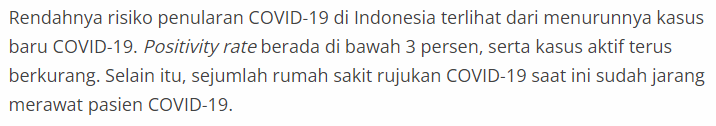
  -   Kebijakan Lepas Masker di Tempat Terbuka, Apakah Tepat? (Ha, 2022)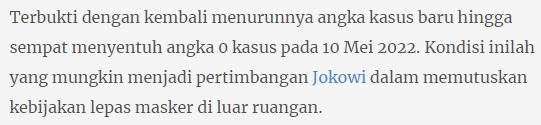
  -   Boleh Lepas Masker, Ini Kebijakan Baru Dari Presiden (Subekti, 2022)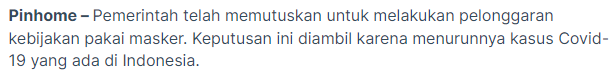

2. Perlu diperhatikan bahwa keputusan ini hanya berlaku *jika masyarakat sedang beraktivitas di luar ruangan, atau di area terbuka yang tidak padat orang* (Putri, 2022). Untuk itu, diperlukan penyelidikan lebih lanjut mengenai relevansi kebijakan ini.
  
  **Problem Statement 2: Apakah angka kasus positif harian Covid-19 memiliki korelasi dengan mobilitas masyarakat di luar ruangan?**
  
  Apabila terbukti kedua variabel ini memiliki korelasi positif, kebijakan ini akan memperparah keadaan Covid-19 di Indonesia. Proyek ini akan berusaha menjawab pertanyaan tersebut dengan melakukan analisis korelasi.

# Data Cleaning and Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
from pmdarima.arima.utils import ndiffs

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import datetime
from datetime import timedelta, date

## Data COVID-19 Indonesia

Agar dapat memprediksi angka kasus positif harian Covid-19 di Indonesia, diperlukan data historis perkembangan kasus Covid-19 di Indonesia. Untuk itu, kita memuat data berikut. (https://tiny.cc/Datacovidjakarta)

In [ ]:
data_covid_indonesia = pd.read_excel("https://tiny.cc/Datacovidjakarta", sheet_name=1)
data_covid_indonesia.head()

,Tanggal,Positif (Indonesia),Dirawat (Indonesia),Sembuh (Indonesia),Meninggal (Indonesia),Meninggal (Jakarta),Sembuh (Jakarta),Self-Isolation (Jakarta),Dirawat (Jakarta),Positif (Jakarta),...,Positif Harian (Indonesia),Dirawat Harian (Indonesia),Sembuh Harian (Indonesia),Meninggal Harian (Indonesia),Meninggal Harian (Jakarta),Sembuh Harian (Jakarta),Self-Isolation Harian (Jakarta),Dirawat Harian (Jakarta),Positif Harian (Jakarta),Positif Aktif Harian (Jakarta)
0,2020-01-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,2,2,0,0,0,0,0,0,0,...,2,2,0,0,0,0,0,0,0,0
3,2020-03-03,2,2,0,0,1,0,0,2,3,...,0,0,0,0,1,0,0,2,3,2
4,2020-03-04,2,2,0,0,1,0,0,2,3,...,0,0,0,0,0,0,0,0,0,0


Perhatikan bahwa terdapat data ini terlewat sepanjang bulan Februari 2020. Untuk mempermudah, tanggal 1 Maret 2020 ditetapkan sebagai tanggal dimulai dan tanggal 26 Juni 2022 ditetapkan sebagai tanggal akhir analisis.

In [ ]:
data_covid_indonesia = data_covid_indonesia.iloc[1:849, :]
data_covid_indonesia.reset_index(drop=True, inplace=True)

Selanjutnya, kita inspeksi kolom-kolom yang terdapat dalam data yang diperoleh.

In [ ]:
data_covid_indonesia.keys()

Index(['Tanggal', 'Positif (Indonesia)', 'Dirawat (Indonesia)',
       'Sembuh (Indonesia)', 'Meninggal (Indonesia)', 'Meninggal (Jakarta)',
       'Sembuh (Jakarta)', 'Self-Isolation (Jakarta)', 'Dirawat (Jakarta)',
       'Positif (Jakarta)', 'Positif Aktif (Jakarta)',
       'Positif Harian (Indonesia)', 'Dirawat Harian (Indonesia)',
       'Sembuh Harian (Indonesia)', 'Meninggal Harian (Indonesia)',
       'Meninggal Harian (Jakarta)', 'Sembuh Harian (Jakarta)',
       'Self-Isolation Harian (Jakarta)', 'Dirawat Harian (Jakarta)',
       'Positif Harian (Jakarta)', 'Positif Aktif Harian (Jakarta)'],
      dtype='object')

Perhatikan bahwa terdapat banyak kolom yang tidak dibutuhkan dalam data ini. Oleh karena itu, kita akan menghapus kolom-kolom yang tidak dibutuhkan.

In [ ]:
data_covid_indonesia = data_covid_indonesia.loc[:, ["Tanggal", "Positif Harian (Indonesia)"]]
data_covid_indonesia.sample(5)

,Tanggal,Positif Harian (Indonesia)
133,2020-07-12,1681
479,2021-06-23,15308
780,2022-04-20,741
341,2021-02-05,11749
114,2020-06-23,1051


Perhatikan bahwa kolom tabel memenuhi pembatas *unique values* sehingga tidak diperlukan pemrosesan lebih lanjut.

In [ ]:
print(data_covid_indonesia["Tanggal"].is_unique)

True


Pengecekan tipe data menunjukkan kolom-kolom dalam data yang dimiliki sudah memiliki format yang sesuai dengan yang diinginkan. Sebagai contoh, kolom "Tanggal" memiliki tipe data "datetime64" dan kolom "Positif Harian (Indonesia)" memiliki tipe data "int64".

In [ ]:
data_covid_indonesia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Tanggal                     848 non-null    datetime64[ns]
 1   Positif Harian (Indonesia)  848 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.4 KB


Hasil analisis statistika deskriptif menunjukkan data berada dalam pembatas jangkauan data. Dalam hal ini, data kasus positif harian harus bernilai lebih dari atau sama dengan nol (tidak ada angka kasus yang bernilai negatif).

In [ ]:
data_covid_indonesia.describe(include=["datetime64[ns]", "int64"], datetime_is_numeric=True)

,Tanggal,Positif Harian (Indonesia)
count,848,848.00000
mean,2021-04-28 12:00:00,7170.34316
min,2020-03-01 00:00:00,0.00000
25%,2020-09-28 18:00:00,615.75000
50%,2021-04-28 12:00:00,3364.50000
75%,2021-11-26 06:00:00,6775.75000
max,2022-06-26 00:00:00,64718.00000
std,NaN,11485.75741


Hasil pengecekan menunjukkan data tidak memiliki *missing values* sehingga tidak dibutuhkan pemrosesan data lebih lanjut.

In [ ]:
data_covid_indonesia.isnull().sum()

Tanggal                       0
Positif Harian (Indonesia)    0
dtype: int64

## Mobility Report

Pertama-tama, impor *dataset* mobility report terlebih dahulu. *Dataset* yang diterbitkan oleh Google dipilih karena merupakan *dataset* yang paling mudah diakses daripada dataset lainnya. *Dataset* Apple sudah tidak dapat diakses lagi dan *dataset* Facebook membutuhkan API untuk mengaksesnya.

In [ ]:
mobility_report = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")
mobility_report.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


Perintah di bawah menampilkan nama-nama kolom yang terdapat dalam *dataset* ini beserta tipe datanya. Perhatikan bahwa kolom "date" belum memenuhi pembatas tipe data. Untuk itu, kita perlu mengubahnya terlebih dahulu.

In [ ]:
mobility_report.keys()

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [ ]:
mobility_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10515365 entries, 0 to 10515364
Data columns (total 15 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   country_region_code                                 object 
 1   country_region                                      object 
 2   sub_region_1                                        object 
 3   sub_region_2                                        object 
 4   metro_area                                          object 
 5   iso_3166_2_code                                     object 
 6   census_fips_code                                    float64
 7   place_id                                            object 
 8   date                                                object 
 9   retail_and_recreation_percent_change_from_baseline  float64
 10  grocery_and_pharmacy_percent_change_from_baseline   float64
 11  parks_percent_change_from_baseline 

In [ ]:
mobility_report["date"] = mobility_report["date"].astype("datetime64")
print(mobility_report["date"])

0          2020-02-15
1          2020-02-16
2          2020-02-17
3          2020-02-18
4          2020-02-19
              ...    
10515360   2022-06-29
10515361   2022-06-30
10515362   2022-07-04
10515363   2022-07-05
10515364   2022-07-06
Name: date, Length: 10515365, dtype: datetime64[ns]


Selanjutnya, terdapat beberapa tahapan pemrosesan data yang harus dilalui.
1.   Data yang ingin dianalisis hanyalah data untuk negara Indonesia.
2.   Data yang ingin dianalisis adalah daa yang berada di negara Indonesia secara umum, bukan provinsi atau kabupaten/kota tertentu.
3.   Data yang ingin dianalisis dimulai dari tanggal 1 Maret 2020
4.   Data yang ingin dianalisis berakhir pada tanggal 26 Juni 2022
5.   Data yang ingin dianalisis hanyalah kolom "date", "retail_and_recreation_percent_change_from_baseline", "grocery_and_pharmacy_percent_change_from_baseline", "parks_percent_change_from_baseline", "transit_stations_percent_change_from_baseline", "workplaces_percent_change_from_baseline", dan "residential_percent_change_from_baseline."


In [ ]:
# Mengambil dataset yang berasal dari negara Indonesia saja.
mobility_report = mobility_report.loc[mobility_report['country_region'] == "Indonesia"]

# Mengambil dataset untuk Indonesia secara umum sehingga bukan merupakan data provinsi tertentu atau kabupaten/kota tertentu.
mobility_report = mobility_report[mobility_report['sub_region_1'].isna()]

# Menetapkan tanggal mulai dan tanggal selesai analisis
mobility_report = mobility_report.loc[mobility_report['date'] > "2020-02-29"]
mobility_report = mobility_report.loc[mobility_report['date'] < "2022-06-27"]

# Menghapus beberapa kolom yang tidak dibutuhkan
mobility_report.drop(mobility_report.columns[[0, 1, 2, 3, 4, 5, 6, 7]], axis=1, inplace=True)

# Menyetel ulang indeks data agar dimulai dari awal.
mobility_report.reset_index(drop = True, inplace = True)

mobility_report

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,1.0,5.0,-8.0,0.0,3.0,1.0
1,2020-03-02,5.0,12.0,0.0,3.0,5.0,0.0
2,2020-03-03,3.0,10.0,-2.0,2.0,5.0,0.0
3,2020-03-04,0.0,4.0,-5.0,-1.0,4.0,1.0
4,2020-03-05,4.0,8.0,-1.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...
843,2022-06-22,12.0,30.0,57.0,-7.0,3.0,15.0
844,2022-06-23,12.0,30.0,52.0,-7.0,4.0,16.0
845,2022-06-24,11.0,29.0,45.0,-7.0,6.0,16.0
846,2022-06-25,11.0,32.0,42.0,-2.0,16.0,13.0


Perhatikan bahwa nama kolom dalam *dataset* ini terlalu panjang sehingga akan menyulitkan analisis ke depannya. Untuk itu, perlu dilakukan penamaan kembali pada kolom

In [ ]:
mobility_report.columns = ['date',
                           'retail and recreation',
                           'grocery and pharmacy',
                           'parks',
                           'transit stations',
                           'workplaces',
                           'residential']
mobility_report.columns

Index(['date', 'retail and recreation', 'grocery and pharmacy', 'parks',
       'transit stations', 'workplaces', 'residential'],
      dtype='object')

Perhatikan bahwa kolom tabel memenuhi pembatas *unique values* sehingga tidak diperlukan pemrosesan lebih lanjut.

In [ ]:
print(mobility_report["date"].is_unique)

True


Hasil pengecekan menunjukkan data tidak memiliki *missing values* sehingga tidak dibutuhkan pemrosesan data lebih lanjut.

In [ ]:
mobility_report.isnull().sum()

date                     0
retail and recreation    0
grocery and pharmacy     0
parks                    0
transit stations         0
workplaces               0
residential              0
dtype: int64

# Exploratory Data Analysis

## Data COVID-19 Indonesia

1. *Descriptive Statistics*

Statistika deskriptif memberikan penjelasan mengenai sifat yang dimiliki *dataset* tersebut. Berikut merupakan hasil perhitungan statistika deskriptif yang dimiliki Data Covid-19 di Indonesia.
- Mean: 7170.34316
- Median: 3364.50000
- Mode: 0
- Standar Deviasi: 11485.75741
- Variansi: 131922623.27643487
- Skewness: 2.6904551406886967. Nilai skewness positif. Hal ini sesuai dengan persebaran nilai mean, median, dan mode yang diperoleh, yaitu mode < median < mean.
- Kurtosis: 7.252142577279967. Nilai kurtosis lebih dari 3 menunjukkan *leptokurtic distribution*. Hal ini menunjukkan data memiliki banyak nilai pencilan.

In [ ]:
data_covid_indonesia.describe(include=["datetime64[ns]", "int64"], datetime_is_numeric=True)

,Tanggal,Positif Harian (Indonesia)
count,848,848.00000
mean,2021-04-28 12:00:00,7170.34316
min,2020-03-01 00:00:00,0.00000
25%,2020-09-28 18:00:00,615.75000
50%,2021-04-28 12:00:00,3364.50000
75%,2021-11-26 06:00:00,6775.75000
max,2022-06-26 00:00:00,64718.00000
std,NaN,11485.75741


In [ ]:
print("Mode: ", data_covid_indonesia.loc[:, "Positif Harian (Indonesia)"].mode())

Mode:  0    0
dtype: int64


In [ ]:
print("Variance: ", data_covid_indonesia.loc[:, "Positif Harian (Indonesia)"].var())

Variance:  131922623.27643487


In [ ]:
print("Skewness: ", data_covid_indonesia.loc[:, "Positif Harian (Indonesia)"].skew())

Skewness:  2.6904551406886967


In [ ]:
print("Kurtosis: ", data_covid_indonesia.loc[:, "Positif Harian (Indonesia)"].kurt())

Kurtosis:  7.252142577279967


2. *Data Visualization*

Diagram garis digunakan untuk menunjukkan perubahan angka Kasus Covid-19 di Indonesia setiap harinya. Diagram garis ini dengan mudah menunjukkan berbagai puncak kasus di berbagai periode waktu.

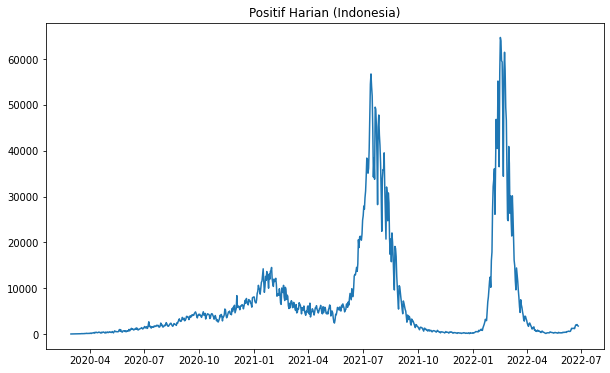

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data_covid_indonesia["Tanggal"], data_covid_indonesia["Positif Harian (Indonesia)"], "-")
plt.title("Positif Harian (Indonesia)")
plt.show()

Selain itu, hasil visualisasi data menunjukkan distribusi angka Kasus Covid-19 di Indonesia memiliki distribusi yang serupa dengan distribusi lognormal (diperlukan uji statistika untuk mengonfirmasi). Hal ini dapat diprediksi berdasarkan hasil statistika deskriptif yang sebelumnya disebutkan.

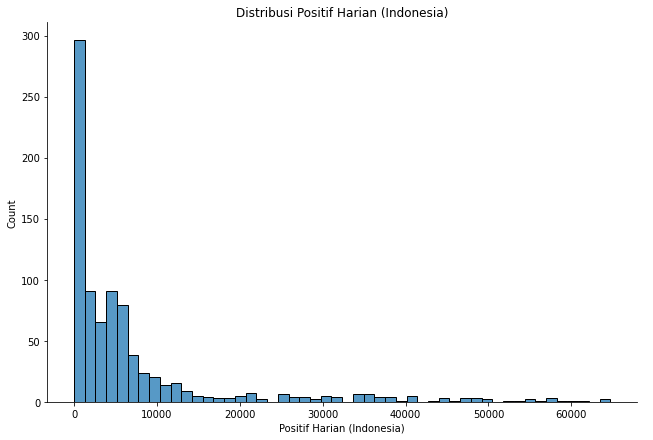

In [ ]:
sns.FacetGrid(data_covid_indonesia, height=6, aspect=1.5).map(sns.histplot,"Positif Harian (Indonesia)").add_legend()
plt.title("Distribusi Positif Harian (Indonesia)")
plt.show()

3. *Autocorrelation*

*Autocorrelation* menunjukkan korelasi sebuah sinyal dengan salinan sinyal tersebut pada beberapa periode waktu sebelumnya. Pemetaan *autocorrelation* dapat memudahkan penemuan sinyal periodik dan pola berulang lainnya.

Dalam Data Covid-19 Indonesia, hasil pemetaan *autocorrelation* menunjukkan angka kasus positif harian Covid-19 sebagai proses yang stasioner (memiliki rata-rata dan standar deviasi yang konstan setiap saat). Hal ini juga menunjukkan tidak adanya *trend* dan *seasonality* yang besar dalam data.

Hasil ini dikonfirmasi lebih lanjut dengan *Augmented Dickey-Fuller test*. Terlihat bahwa p-value bernilai kurang dari 0.05 yang berarti data merupakan data stasioner.

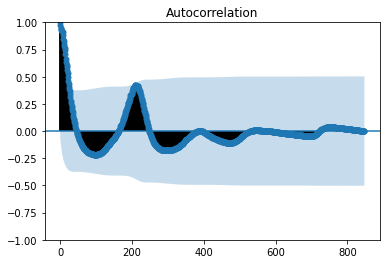

In [ ]:
plot_acf(data_covid_indonesia["Positif Harian (Indonesia)"], lags=len(data_covid_indonesia)-1, alpha = 0.05)
plt.show()

In [ ]:
# Augmented Dickey-Fuller Test
ndiffs(data_covid_indonesia["Positif Harian (Indonesia)"], test='adf')

0

4. *Decomposition*
*Decomposition* memecah data *time-series* menjadi beberapa kategori yang masing-masing menunjukkan satu kategori pola.

Analisis dilakukan dengan model ETS (Error-Trend-Seasonality) dalam melakukan dekomposisi. Umumnya, model *additive* cocok digunakan apabila besar fluktuasi tidak berubah-ubah (Rink, 2022). Selain itu, model *additive* dipilih karena terdapat data bernilai nol (model *multiplicative* tidak dapat berjalan apabila terdapat data bernilai nol).

Menurut Harian (2022), musim kemarau di Indonesia terjadi  pada bulan Mei hingga September dan musim hujan di Indonesia terjadi pada bulan Oktober hingga April. Hasil dekomposisi menunjukkan puncak kasus Covid-19 terjadi di tengah berjalannya kedua musim ini. Hal ini selaras dengan yang disampaikan PBB bahwa Covid-19 akan menjadi penyakit musiman (Iswara, 2021).

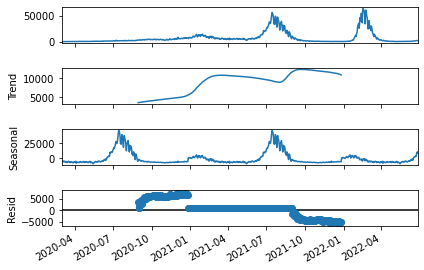

In [ ]:
fig = data_covid_indonesia.set_index('Tanggal', drop=True, inplace = False)
fig = seasonal_decompose(fig, model='additive', period=365).plot()
fig.autofmt_xdate()
plt.show()

## Mobility Report

1. *Descriptive Statistics*

Berikut merupakan statistika deskriptif untuk data *mobility report*. Statistika deskriptif ini menyimpulkan berbagai karakteristik yang dimiliki masing-masing data.

In [ ]:
desc_stats = mobility_report.describe(include=["datetime64[ns]", "float64"], datetime_is_numeric=True).transpose()
desc_stats = pd.concat([desc_stats,
                        mobility_report.var(numeric_only=True),
                        mobility_report.mode(numeric_only=True).dropna().transpose(),
                        mobility_report.skew(numeric_only=True),
                        mobility_report.kurt(numeric_only=True)],
                       axis=1, join='outer')
desc_stats.columns = keys=['count', 'mean', 'min', '25%', '50%', '75%', 'max', 'std', 'var', 'mode', 'skew', 'kurt']
desc_stats.transpose()

,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential
count,848,848.0,848.0,848.0,848.0,848.0,848.0
mean,2021-04-28 12:00:00,-9.132075,10.964623,-2.642689,-27.633255,-16.957547,9.799528
min,2020-03-01 00:00:00,-53.0,-34.0,-58.0,-68.0,-73.0,0.0
25%,2020-09-28 18:00:00,-19.0,-2.0,-18.0,-37.0,-26.0,6.0
50%,2021-04-28 12:00:00,-12.5,10.5,-8.0,-29.0,-20.0,9.0
75%,2021-11-26 06:00:00,4.0,25.0,5.0,-17.0,-6.0,13.0
max,2022-06-26 00:00:00,45.0,74.0,214.0,18.0,29.0,25.0
std,NaN,15.717594,17.214424,27.661231,14.848187,16.763459,4.46922
var,NaN,247.042748,296.336409,765.143725,220.468645,281.013544,19.973931
mode,NaN,-16.0,2.0,-9.0,-31.0,-25.0,5.0


2. *Data Visualization*

Visualisasi dilakukan dengan diagram garis untuk menunjukkan perubahan data untuk setiap waktunya. Terdapat beberapa hal penting yang diperoleh dari hasil visualisasi data.
*   Saat Covid-19 pertama kali merebak, tempat publik seperti "retail and recreation, "transit stations", "parks", dan "grocery and pharmacy", "workplaces" mengalami penurunan jumlah kunjungan. Namun, "residential" mengalami kenaikan jumlah kunjungan.
*   Semakin berjalannya waktu, tempat publik mulai kembali dikunjungi orang-orang. Sebaliknya, tempat residential mengalami penurunan jumlah kunjungan.
*   "Workplaces" mengalami perubahan secara periodik setiap minggunya. Orang-orang cenderung libur di akhir minggu.

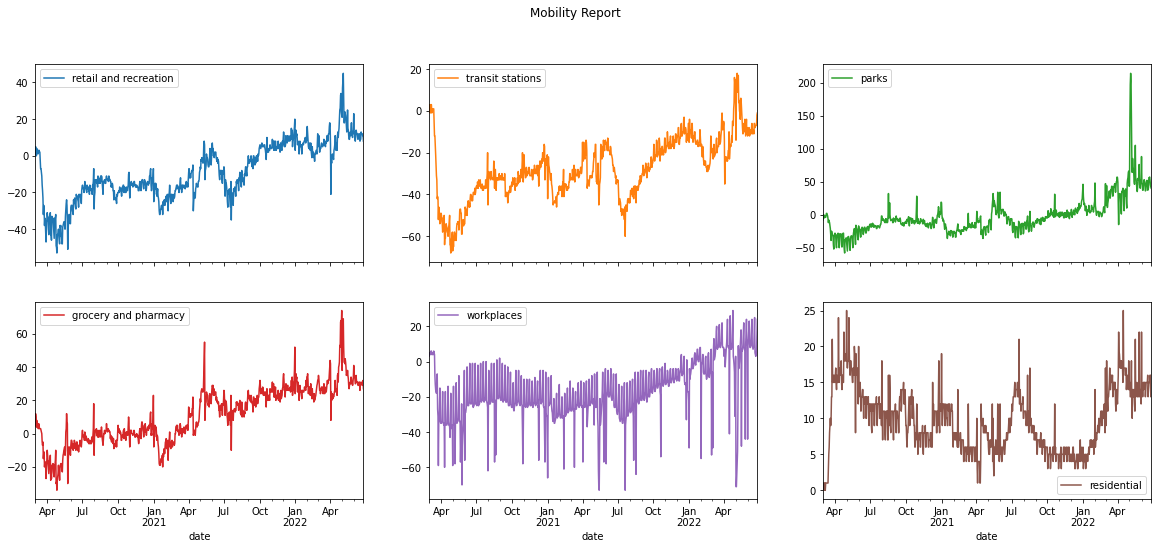

In [160]:
mobility_report.plot(x='date', y=['retail and recreation', 'transit stations', 'parks',
                                  'grocery and pharmacy', 'workplaces', 'residential'],
                     subplots=True, figsize=(20, 8), layout=(2, 3), title='Mobility Report')
plt.show()

Perintah berikut digunakan untuk menampilkan distribusi nilai kunjungan untuk setiap tempat. Bentuk distribusi kunjungan ini sesuai dengan nilai *descriptive statistics* yang sebelumnya sudah ditemukan. Terlihat bahwa sebagian besar kolom memiliki distribusi data menyerupai distribusi normal (dibutuhkan uji statistika untuk mengonfirmasi).

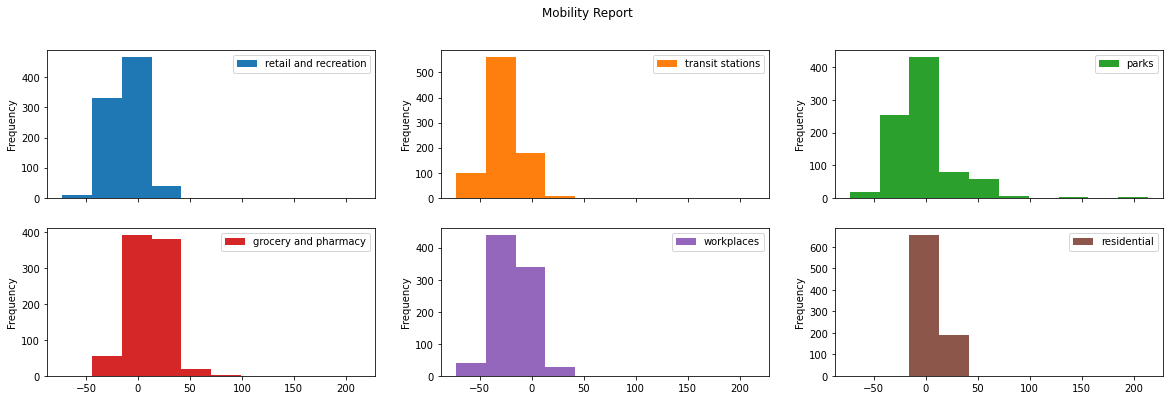

In [163]:
mobility_report.plot(y=['retail and recreation', 'transit stations', 'parks', 'grocery and pharmacy', 'workplaces', 'residential'],
                     subplots=True, kind="hist", figsize=(20, 8), layout=(2, 3), title='Mobility Report')
plt.show()

3. *Correlation*
*Correlation* menunjukkan hubungan statistika antara dua variabel. Dalam statistika, *correlation* menunjukkan seberapa berhubungan dua variabel dalam data. Hubungan ini ditunjukkan dengan hubungan linear.
*   Korelasi bernilai 1 menunjukkan hubungan linear yang sebanding. Ketika satu variabel mengalami pertambahan nilai, variabel lainnya akan bertambah juga.
*   Korelasi bernilai -1 menunjukkan hubungan linear yang berbanding terbalik. Ketika satu variabel mengalami pertambahan nilai, variabel lainnya akan berkurang.
*   Korelasi bernilai 0 menunjukkan kedua variabel tidak berhubungan secara linear.

Terdapat beberapa hal penting yang dapat diperoleh dari hasil analisis korelasi berikut.
1. Variabel "resident" berkorelasi negatif dengan variabel lainnya kecuali dengan "parks"
2. Variabel "retail and recreation", "grocery and pharmacy", "parks", dan "transit stations" memiliki korelasi yang tinggi antarsatu sama lain.

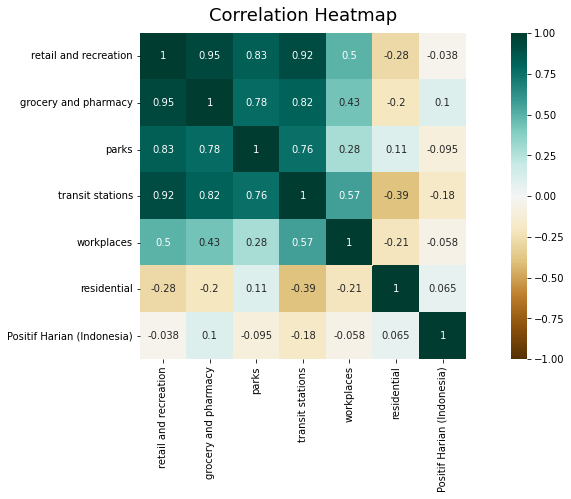

In [214]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(mobility_report.corr(),
                      vmin = -1, vmax = 1,
                      annot = True, cmap = 'BrBG', cbar=True, square=True)
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize':18}, pad = 12);

## Data COVID-19 Indonesia and Mobility Report Correlation

Pada bagian ini, kita ingin melihat korelasi mobility report dengan angka kasus positif harian Covid-19 di Indonesia. Pertama-tama, gabungkan data yang ingin dibuat korelasinya.

In [237]:
correlation_data = mobility_report
correlation_data["Positif Harian (Indonesia)"] = data_covid_indonesia["Positif Harian (Indonesia)"]
correlation_data

,date,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,Positif Harian (Indonesia)
0,2020-03-01,1.0,5.0,-8.0,0.0,3.0,1.0,0
1,2020-03-02,5.0,12.0,0.0,3.0,5.0,0.0,2
2,2020-03-03,3.0,10.0,-2.0,2.0,5.0,0.0,0
3,2020-03-04,0.0,4.0,-5.0,-1.0,4.0,1.0,0
4,2020-03-05,4.0,8.0,-1.0,3.0,4.0,0.0,0
...,...,...,...,...,...,...,...,...
843,2022-06-22,12.0,30.0,57.0,-7.0,3.0,15.0,1985
844,2022-06-23,12.0,30.0,52.0,-7.0,4.0,16.0,1907
845,2022-06-24,11.0,29.0,45.0,-7.0,6.0,16.0,2069
846,2022-06-25,11.0,32.0,42.0,-2.0,16.0,13.0,1831


Selanjutnya, hitung korelasinya dan petakan korelasi ke dalam heatmap. Hasil korelasi menunjukkan tidak ada hubungan yang kuat antara kasus positif harian Covid-19 di Indonesia dengan pergerakan masyarakat.

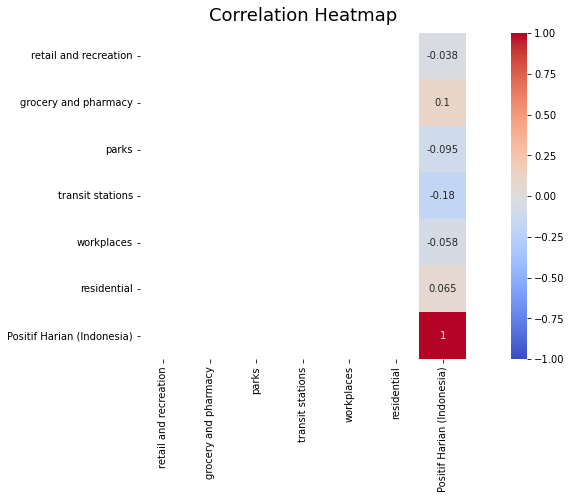

In [236]:
mask = np.ones_like(correlation_data.corr(), dtype=bool)
for i in range(len(mask)):
  mask[i][6] = False

plt.figure(figsize=(16,6))
heatmap = sns.heatmap(correlation_data.corr(), vmin = -1, vmax = 1,
                      annot = True, cmap = 'coolwarm', cbar=True, square=True, mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize':18}, pad = 12);

# Modelling

## Classical Machine Learning Model

Fungsi berikut digunakan untuk memproses data *time-series*. Umumnya, kita ingin memprediksi data futur berdasarkan data masa lalu (Rosenthal, 2018). Agar dapat melakukan hal ini, kita partisi data yang diperoleh menjadi beberapa time window.

In [164]:
window_size = 64
batch_size = 32

def to_time_window(series, window_size=64, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds

X_mat = np.asarray([])
y_mat = np.asarray([])

for X, y in to_time_window(data_covid_indonesia["Positif Harian (Indonesia)"]):
  X_mat = np.append(X_mat, X)
  y_mat = np.append(y_mat, y)

y_mat = y_mat.ravel()
X_mat = X_mat.reshape(len(y_mat), window_size)

split_time = int(len(data_covid_indonesia)*0.8)

y_train_mat = y_mat[:split_time-window_size]
X_train_mat = X_mat[:split_time-window_size,]

y_test_mat = y_mat[split_time-window_size:]
X_test_mat = X_mat[split_time-window_size:, :]

Perintah berikut digunakan untuk melakukan *hyperparameter tuning* untuk setiap model pembelajaran mesin klasik yang dipilih. Beberapa model pembelajaran mesin yang dipilih adalah
1.   Linear Regression
2.   Ridge
3.   Bayesian Ridge
4.   k-Neighbors Regression
5.   Decision Tree Regression
6.   Support Vector Regression
Hasil *hyperparameter tuning* kemudian dimasukkan kembali ke dict_regressors.



In [165]:
dict_regressors = {"Linear Regression": LinearRegression(fit_intercept=False),
                  "Ridge": Ridge(fit_intercept=False),
                   "Bayesian Ridge": BayesianRidge(fit_intercept=False),
                   "k-Neighbors Regressor": KNeighborsRegressor(p=2, metric="euclidean"),
                   "Decision Tree Regressor": DecisionTreeRegressor(criterion="absolute_error"),
                   "Support Vector Regressor": SVR(kernel="rbf", degree=3)
                   }

params = {"Linear Regression": {"positive": [True, False]},
          "Ridge": {"alpha": [0.01, 0.1, 1, 10, 100], "solver": ["svd", "cholesky", "lsqr", "sag"]},
          "Bayesian Ridge": {"alpha_1": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
                             "alpha_2": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
                             "lambda_1": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
                             "lambda_2": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]},
          "k-Neighbors Regressor": {"n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                  "weights": ["uniform", "distance"],
                                  "algorithm": ["ball_tree", "kd_tree", "brute"],
                                  "leaf_size": [15, 20, 25, 30, 35, 40, 45, 50]},
          "Decision Tree Regressor": {"splitter": ["best", "random"],
                                      "max_depth" : [1, 3, 5],
                                      "min_samples_leaf":[1, 2, 3],
                                      "min_weight_fraction_leaf":[0.1, 0.2, 0.3],
                                      "max_leaf_nodes":[None, 10, 20, 30]},
          "Support Vector Regressor": {"C": [0.01, 0.1, 1],
                                       "gamma": [0.01, 0.1, 1],
                                       "epsilon": [0.01, 0.1, 1],
                                       "shrinking": [True, False]}
          }


for regressor_name in dict_regressors.keys() & params:
    print(regressor_name, ": ", end="")
    gridSearch = GridSearchCV(estimator=dict_regressors[regressor_name], param_grid=params[regressor_name],
                              scoring="neg_mean_absolute_error")
    gridSearch.fit(X_train_mat, y_train_mat)
    print(gridSearch.best_score_, gridSearch.best_params_)
    dict_regressors[regressor_name] = gridSearch.best_estimator_

Linear Regression : -930.281762364972 {'positive': True}
Bayesian Ridge : -1051.6386035415564 {'alpha_1': 1e-07, 'alpha_2': 0.01, 'lambda_1': 0.01, 'lambda_2': 1e-07}
k-Neighbors Regressor : -3733.180513701523 {'algorithm': 'ball_tree', 'leaf_size': 15, 'n_neighbors': 4, 'weights': 'distance'}
Support Vector Regressor : -6026.113887778221 {'C': 1, 'epsilon': 1, 'gamma': 0.01, 'shrinking': True}
Decision Tree Regressor : -3423.385512461682 {'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'random'}
Ridge : -999.1814942947861 {'alpha': 0.1, 'solver': 'sag'}


Selanjutnya, kita ingin mengukur performa model kita dengan membandingkan hasil prediksi dan data sebenarnya. Performa model diukur dengan *mean absolute error*.

In [166]:
for regressor_name in dict_regressors.keys():
  best_estimator = dict_regressors[regressor_name]
  best_estimator.fit(X_train_mat, y_train_mat)
  best_estimator_forecast = best_estimator.predict(X_test_mat)
  print(regressor_name, 'MAE:', tf.keras.metrics.mean_absolute_error(y_test_mat, best_estimator_forecast).numpy())

Linear Regression MAE: 2157.3843610607996
Ridge MAE: 2215.5773763909265
Bayesian Ridge MAE: 2254.0670659637
k-Neighbors Regressor MAE: 5130.400998876448
Decision Tree Regressor MAE: 5709.594117647059
Support Vector Regressor MAE: 10593.235294117647


## Deep Learning Model

Awalnya, definisikan sebuah fungsi untuk menghasilkan *time-window* dan variabel target berdasarkan data historis yang telah diperoleh.

Selanjutnya, kita juga akan mendefinisikan berbagai variabel, seperti "window_size", "batch_size", dan "shuffle_buffer".

In [167]:
window_size = 64
batch_size = 32
shuffle_buffer = 1000

def seq2seq_window_dataset(series, window_size=64, batch_size=32):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

Selanjutnya, kita bagi *dataset* yang sebelumnya diperoleh menjadi *train data*, *validation data*, dan *test data*. *Validation data* diperlukan agar model pembelajaran mendalam yang dilatih tidak rentan terhadap *overfitting*.

Menurut Baheti (2022), tidak ada aturan umum mengenai pembagian *dataset*. Namun, beliau menyebutkan "a large split of data should be kept in training set with a validation set" apabila model *neural network* seperti pembelajaran mendalam digunakan. Kita akan menggunakan pembagian berikut ini
*   Training data: 70%
*   Validation data: 15%
*   Test data: 15%


In [183]:
train_val_split = int(len(data_covid_indonesia)*0.7)
val_test_split = int(len(data_covid_indonesia)*0.85)

tanggal_train = data_covid_indonesia["Tanggal"][:train_val_split]
tanggal_valid = data_covid_indonesia["Tanggal"][train_val_split:val_test_split]
tanggal_test = data_covid_indonesia["Tanggal"][val_test_split:]

y_train = data_covid_indonesia["Positif Harian (Indonesia)"][:train_val_split]
y_valid = data_covid_indonesia["Positif Harian (Indonesia)"][train_val_split:val_test_split]
y_test = data_covid_indonesia["Positif Harian (Indonesia)"][val_test_split:]

Inisialisasi pelatihan model pembelajaran mendalam. Inisialisasi ini bertujuan untuk memilih *learning rate* yang sesuai dengan model.

Model dibangun berdasarkan model yang mirip dengan WaveNet Architecture (Kumar, 2021). Model ini dipilih karena secara teori mampu mengenali *long term signal* dan *short term signal* secara bersamaan.

In [184]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set = seq2seq_window_dataset(y_train)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      tf.keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
17/17 [==============================] - 2s 29ms/step - loss: 7796.7090 - mae: 7797.2080 - lr: 1.0000e-04
Epoch 2/100
17/17 [==============================] - 1s 27ms/step - loss: 7654.5879 - mae: 7655.0879 - lr: 1.0798e-04
Epoch 3/100
17/17 [==============================] - 1s 27ms/step - loss: 7477.7744 - mae: 7478.2739 - lr: 1.1659e-04
Epoch 4/100
17/17 [==============================] - 1s 26ms/step - loss: 7170.0903 - mae: 7170.5898 - lr: 1.2589e-04
Epoch 5/100
17/17 [==============================] - 1s 27ms/step - loss: 6589.4912 - mae: 6589.9912 - lr: 1.3594e-04
Epoch 6/100
17/17 [==============================] - 1s 26ms/step - loss: 5691.9199 - mae: 5692.4199 - lr: 1.4678e-04
Epoch 7/100
17/17 [==============================] - 1s 26ms/step - loss: 4806.1279 - mae: 4806.6274 - lr: 1.5849e-04
Epoch 8/100
17/17 [==============================] - 1s 27ms/step - loss: 4240.9326 - mae: 4241.4326 - lr: 1.7113e-04
Epoch 9/100
17/17 [==============================] - 1s 

Hasil pemetaan *learning rate* terhadap *loss function* menunjukkan *learning rate* terbaik untuk model ini adalah 1e-3. Hal ini terlihat dari *loss function* yang cukup *smooth* di sekitar *learning rate* 5e-4.

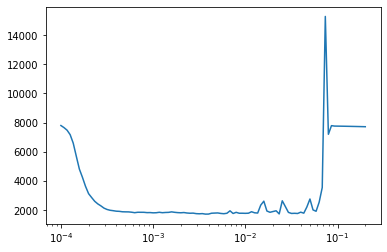

In [185]:
plt.semilogx(history.history["lr"], history.history["loss"])

Setelah menetapkan *learning rate*, latih kembali model pembelajaran mendalam. Model pembelajaran mendalam ini akan disimpan agar dapat dengan mudah diakses kembali.

In [186]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set = seq2seq_window_dataset(y_train)
valid_set = seq2seq_window_dataset(y_valid)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2,
                                     strides=1, dilation_rate=dilation_rate,
                                     padding="causal", activation="relu")
    )
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)

history = model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
17/17 [==============================] - 3s 63ms/step - loss: 7007.0215 - mae: 7007.5215 - val_loss: 2022.9878 - val_mae: 2023.4875
Epoch 2/500
17/17 [==============================] - 1s 34ms/step - loss: 5340.5928 - mae: 5341.0923 - val_loss: 1677.8065 - val_mae: 1678.3059
Epoch 3/500
17/17 [==============================] - 1s 33ms/step - loss: 4220.4897 - mae: 4220.9888 - val_loss: 1460.2969 - val_mae: 1460.7963
Epoch 4/500
17/17 [==============================] - 1s 32ms/step - loss: 3310.2107 - mae: 3310.7104 - val_loss: 1019.4628 - val_mae: 1019.9617
Epoch 5/500
17/17 [==============================] - 1s 33ms/step - loss: 2664.0684 - mae: 2664.5681 - val_loss: 786.5583 - val_mae: 787.0572
Epoch 6/500
17/17 [==============================] - 1s 30ms/step - loss: 2310.2061 - mae: 2310.7058 - val_loss: 656.4927 - val_mae: 656.9911
Epoch 7/500
17/17 [==============================] - 1s 34ms/step - loss: 2068.4453 - mae: 2068.9451 - val_loss: 595.7881 - val_mae: 596.287

In [187]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 dropout (Dropout)           (None, None, 32)          0

In [188]:
model = tf.keras.models.load_model("my_checkpoint.h5")

Definisikan fungsi untuk memprediksi data masa depan berdasarkan data historis dengan menggunakan model pembelajaran mendalam yang sebelumnya telah dibuat. Kemudian, hasil prediksi (cnn_forecast) akan dibandingkan dengan nilai sebenarnya (x_valid) dengan menggunakan metrik *mean absolute error*. Hasil perbandingan ini akan menjadi performa model kita.

In [189]:
def model_forecast(model, series, window_size=64):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [190]:
cnn_forecast = model_forecast(model, data_covid_indonesia["Positif Harian (Indonesia)"])
cnn_forecast = cnn_forecast[val_test_split-window_size:-1, -1, 0]

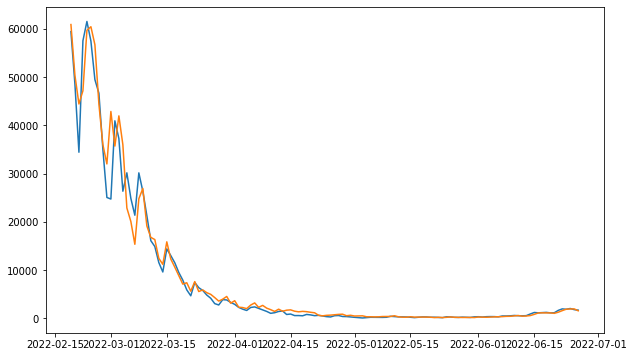

In [191]:
plt.figure(figsize=(10, 6))
plt.plot(tanggal_test, y_test)
plt.plot(tanggal_test, cnn_forecast)

In [192]:
tf.keras.metrics.mean_absolute_error(y_test, cnn_forecast).numpy()

1150.4462

## Model Selection

Setelah pelatihan model dilakukan, saatnya untuk membandingkan performa masing-masing model. Terlihat bahwa model *Deep Learning* merupakan model dengan performa terbaik.

In [193]:
for regressor_name in dict_regressors.keys():
  best_estimator = dict_regressors[regressor_name]
  best_estimator.fit(X_train_mat, y_train_mat)
  best_estimator_forecast = best_estimator.predict(X_test_mat)
  print(regressor_name, 'MAE:', tf.keras.metrics.mean_absolute_error(y_test_mat, best_estimator_forecast).numpy())

print("Deep Learning", 'MAE:', tf.keras.metrics.mean_absolute_error(y_test, cnn_forecast).numpy())

Linear Regression MAE: 2157.3843610607996
Ridge MAE: 2207.8859256762794
Bayesian Ridge MAE: 2254.0670659637
k-Neighbors Regressor MAE: 5130.400998876448
Decision Tree Regressor MAE: 3610.085294117647
Support Vector Regressor MAE: 10593.235294117647
Deep Learning MAE: 1150.4462


Selanjutnya, kita ingin memprediksi data futur dengan model pembelajaran mendalam yang telah dibangun berdasarkan data historis.

In [194]:
start_date = date(2022, 6, 27)
end_date = date(2024, 1, 1)
days_to_the_future = int((end_date - start_date).days)

series = data_covid_indonesia.iloc[-window_size:, 1].to_numpy()

for i in range(days_to_the_future):
  ds = series[-window_size:]
  ds = tf.expand_dims(ds, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(ds)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  forecast = forecast[:, -1, 0]
  series = np.append(series, int(forecast))
series = series[window_size:]
series

array([1639, 1790, 1782, 1846, 1928, 1806, 1625, 1583, 1667, 1704, 1741,
       1779, 1651, 1503, 1458, 1573, 1635, 1676, 1656, 1505, 1333, 1309,
       1429, 1504, 1522, 1510, 1366, 1206, 1152, 1239, 1249, 1290, 1269,
       1150,  968,  948, 1010, 1011, 1035, 1001,  887,  720,  723,  766,
        746,  771,  728,  622,  481,  514,  540,  535,  535,  478,  373,
        296,  314,  331,  321,  310,  267,  214,  182,  189,  203,  201,
        186,  170,  151,  129,  131,  137,  144,  137,  133,  120,  102,
        101,  109,  123,  124,  117,  107,   91,   93,  109,  126,  128,
        126,  117,  102,  101,  117,  126,  135,  133,  121,  101,   99,
        108,  118,  127,  128,  117,   96,   93,  106,  112,  120,  120,
        109,   89,   88,  102,  110,  118,  121,  111,   94,   92,  109,
        116,  127,  135,  130,  114,  113,  128,  139,  152,  162,  159,
        146,  143,  156,  171,  187,  201,  200,  188,  183,  193,  210,
        229,  245,  244,  233,  224,  230,  245,  2

In [195]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

time = []
for single_date in daterange(start_date, end_date):
  time.append(single_date)
print(time)

[datetime.date(2022, 6, 27), datetime.date(2022, 6, 28), datetime.date(2022, 6, 29), datetime.date(2022, 6, 30), datetime.date(2022, 7, 1), datetime.date(2022, 7, 2), datetime.date(2022, 7, 3), datetime.date(2022, 7, 4), datetime.date(2022, 7, 5), datetime.date(2022, 7, 6), datetime.date(2022, 7, 7), datetime.date(2022, 7, 8), datetime.date(2022, 7, 9), datetime.date(2022, 7, 10), datetime.date(2022, 7, 11), datetime.date(2022, 7, 12), datetime.date(2022, 7, 13), datetime.date(2022, 7, 14), datetime.date(2022, 7, 15), datetime.date(2022, 7, 16), datetime.date(2022, 7, 17), datetime.date(2022, 7, 18), datetime.date(2022, 7, 19), datetime.date(2022, 7, 20), datetime.date(2022, 7, 21), datetime.date(2022, 7, 22), datetime.date(2022, 7, 23), datetime.date(2022, 7, 24), datetime.date(2022, 7, 25), datetime.date(2022, 7, 26), datetime.date(2022, 7, 27), datetime.date(2022, 7, 28), datetime.date(2022, 7, 29), datetime.date(2022, 7, 30), datetime.date(2022, 7, 31), datetime.date(2022, 8, 1), d

Kemudian, hasil prediksi ini dipetakan ke dalam diagram garis. Hasil prediksi menunjukkan angka positif harian Covid-19 akan memuncak pada angka di sekitar angka 2000 di bulan Juli. Kemudian, akan turun kembali. Akhirnya, Covid-19 di Indonesia akan menjadi penyakit musiman sepanjang tahun 2023. Angka positif harian Covid-19 akan memantul-mantul sepanjang tahun 2023 dengan berpuncak di pertengahan musim hujan dan musim kemarau.

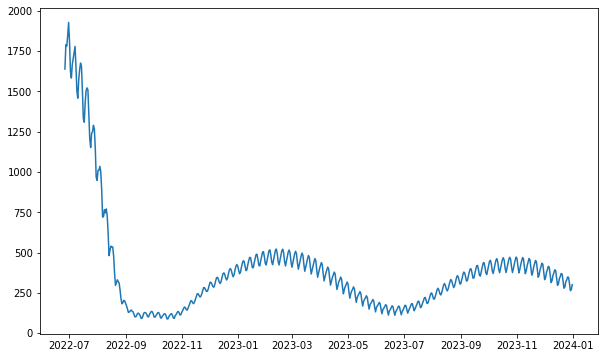

In [196]:
plt.figure(figsize=(10, 6))
plt.plot(time, series, '-')

# Conclusion

Simpulan yang diperoleh adalah sebagai berikut
1. Angka kasus positif harian Covid-19 di Indonesia akan tetap rendah. Covid-19 akan menjadi penyakit musiman yang dihadapi masyarakat setiap pertengahan musim.
2. Tidak terdapat korelasi antara kasus positif harian Covid-19 di Indonesia dengan kunjungan masyarakat ke luar ruangan.

Dengan demikian, aturan pelonggaran masker merupakan keputusan yang tepat. Masyarakat tidak perlu terlalu khawatir mengenai penyebaran Covid-19 karena penyakit ini hanya akan menjadi penyakit musiman.

# Daftar Pustaka

A. (2022, May 20). Kebijakan Lepas Masker Ditetapkan, Ini Pendapat IDI. Tempo. https://gaya.tempo.co/read/1593364/kebijakan-lepas-masker-ditetapkan-ini-pendapat-idi

Baheti, P. (2022, June 20). Train Test Validation Split: How To & Best Practices [2022]. V7. https://www.v7labs.com/blog/train-validation-test-set

Ha, A. (2022, June 21). Kebijakan Lepas Masker di Tempat Terbuka, Apakah Tepat? Halaman 1 - Kompasiana.com. KOMPASIANA. https://www.kompasiana.com/avantih/62b1f161bb4486399d35e894/kebijakan-lepas-masker-di-tempat-terbuka-apakah-tepat

Harian, K. (2022, January 12). Ada Berapa Musim di Indonesia? Ini Penjelasannya. kumparan. https://kumparan.com/kabar-harian/ada-berapa-musim-di-indonesia-ini-penjelasannya-1xIEiobq7Ih

Iswara, A. J. (2021, March 18). Covid-19 Akan Jadi Penyakit Musiman, PBB Paparkan Buktinya. KOMPAS.Com. https://www.kompas.com/global/read/2021/03/18/091736670/covid-19-akan-jadi-penyakit-musiman-pbb-paparkan-buktinya

Kumar, S. (2021, December 10). Understanding WaveNet architecture - Satyam Kumar. Medium. https://medium.com/@satyam.kumar.iiitv/understanding-wavenet-architecture-361cc4c2d623

Putri, Z. (2022, May 17). Pernyataan Lengkap Jokowi Bolehkan Lepas Masker di Outdoor. detiknews. https://news.detik.com/berita/d-6081856/pernyataan-lengkap-jokowi-bolehkan-lepas-masker-di-outdoor